# Simple Conceptual Model of the D-O Oscillation

This notebook uses a Python environment with a few libraries, all of which were specificied in the first cell of this notebook below.

In [1]:
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import FancyBboxPatch
import matplotlib.lines as mlines

import cftime

import ipywidgets as widgets
from ipywidgets import interact,interactive
from ipywidgets import Checkbox

import nsim

%matplotlib inline

In [2]:
def setaxesfsize(axl,fontsize):
    ticklabelbot = axl.get_xticklabels()
    ticklabelleft = axl.get_yticklabels()
    for labelx in ticklabelbot:
        labelx.set_fontsize(fontsize)
    for labely in ticklabelleft:
            labely.set_fontsize(fontsize)

In [3]:
def nond_gv_abs_getdata_amoc_aabw(tau, c, d, s, tlen, dw, stochastic=False, Heinrich=False):
    

    if Heinrich:
        xic = 2
        yic = 2
        y0 = np.array([yic, xic])
    else:
        xic = 0.
        yic = 1.5
        y0 = np.array([yic, xic])
    
    def f(y, t):
        D = 1000.0 #m
        V = 7.0e15 #m^3
        # NEOS
        #a, b =  -1.1e7, 3.1e9
        # LEOS
        # characteristic times, moc , etc.
        secpryr = 3600.0 * 24.0 * 365.0
        F0 = d/secpryr # 1m/yr/(sec/yr) = [m/s]
        tc = D/(2*F0) # charactertic time (500 years in seconds)
        a_amoc, b_amoc = -4.5e6, 5.e9
        b_aabw = 0.5e16 # this is A/b_0 area of ocean over mean buoancy gradient)
        A = 7.5e12 #m^2
        qc = A*F0 #characteristic MOC
        #qc = 15.0e6 #characteristic MOC Sv
        db0 = 0.004 # charateristic buoyancy gradient
        dB0 = db0*F0 # characteristic buoyancy flux
        #return -1.0*np.abs((a/qc) + (b/(qc/db0))*(db+dbshift)/db0)*(db+dbshift)/db0 + Bshift/dB0
        # non-dimensionalize
        a, b =  -6e6/qc, 2.0e9/(qc/db0)

        dbshift = -0.0025/db0
        taup = (tau*secpryr)/tc
        cp = c/db0
        cpmid = (20.0*1.0e6 - a_amoc)/b_amoc/db0
        cpBfact = 0.65
        Bshift = 2.0e-9/dB0 + (cpmid - cp)*cpBfact
        return np.array([ -(y[1] - Bshift) - (y[0] + dbshift)*np.abs(a + b*(y[0] + dbshift)), 
                          (1/taup)*(y[0] - s*y[1] - cp)])

    if stochastic:
        # Noise function
        #dw = 0.02 # noise level
        Br = np.diag([dw, dw]) # add O-U process on both equations
        def G(y, t):
            return Br
        Model = nsim.newmodel(f, G, y0, modelType=nsim.ItoModel)
    else:
        # no noise
        Model = nsim.newmodel(f, None, y0, modelType=nsim.ODEModel)

    stom_gv1 = nsim.Simulation(Model, T=tlen)
    xdata_gv1 = stom_gv1.timeseries[:,0]
    ydata_gv1 = stom_gv1.timeseries[:,1]
    tdata_gv1 = stom_gv1.timeseries.t.ts.tspan
    
    def yman(y, c):
        #qc = 15.0e6 #characteristic MOC Sv
        tau, d, s, tlen = (500, 10.0, 0.001, 200)
        # Output
        #dw = 0.02 # noise level


        D = 1000.0 #m
        V = 7.0e15 #m^3
        secpryr = 3600.0 * 24.0 * 365.0
        F0 = d/secpryr # 1m/yr/(sec/yr) = [m/s]
        A = 7.5e12 #m^2
        F0 = d/secpryr # 1m/yr/(sec/yr) = [m/s]
        qc = A*F0 #characteristic MOC
        db0 = 0.004 # charateristic buoyancy gradient
        a_amoc, b_amoc = -4.5e6, 5.e9
        b_aabw = 0.5e16 # this is A/b_0 area of ocean over mean buoancy gradient)
        db0 = 0.004 # charateristic buoyancy gradient
        dB0 = db0*F0 # characteristic buoyancy flux
        cp = c/db0
        cpmid = (20.0*1.0e6 - a_amoc)/b_amoc/db0
        cpBfact = 0.65

        Bshift = 2.0e-9/dB0 + (cpmid - cp)*cpBfact
        dbshift = -0.0025/db0
        a, b =  -6e6/qc, 2.0e9/(qc/db0)
        p = -(y + dbshift)*np.abs(a + b*(y + dbshift)) + Bshift
        return p

    def bman(y, c, s):
        db0 = 0.004 # charateristic buoyancy gradient
        p = c/db0 + y*s
        return p  
    

    ysnd = np.linspace(0,2,201)
    bxnd = np.linspace(-2,20,201)

    psnd = yman(ysnd, c)
    clinend = bman(bxnd, c, s)
    return ysnd, bxnd, psnd, clinend, xdata_gv1, ydata_gv1, tdata_gv1


In [4]:
# produce a function for simple heuristic model, input co2
def shm(co2arr, dotsize, stochastic = False, dw = 0.02):

    fig = plt.figure(figsize=(26,10))

    ##### plot dependance on CO2

    # SM timeseries panels
    ac0 = plt.subplot(121)
    ac = ac0
    ac_lr = ac0.twinx()
    # SM phase portraits

    ac0r = plt.subplot(122)
    acr = ac0r

    #######################################################################################################
    ######## Conceptual Climate Model of the D-O oscillation
    #######################################################################################################

    # plot parameters
    # averaging of model timeseries
    timemean = 10 # 100 years

    axeslsize = 20  # axes label font size
    legfsize = 18 # leg label font size
    axnumsize = 18  # axes num font size
    xmin = cftime.num2date(0*365, 'days since 0000-01-01 00:00:00', calendar='noleap')
    xmax = cftime.num2date(10000*365, 'days since 0000-01-01 00:00:00', calendar='noleap')
    ymin = 1 # right axis range
    ymax = 29
    rymin = -26 # left axis range
    rymax = -6
    legloc = (0.6,0.7) # AMOC legend location
    rlegloc = (0.01,0.1) # AABW legend location

    legcol = 1 # legend color index (see above)

    # manifold thinkness and transparency
    manilw1 = 10.0 # slowmanifold top and bottom width
    manilw1a = 2.0 # unstable branch of slowmanifold
    manilw2 = 5.0 # co2 nullcline
    manialp1 = 0.3 # slowmanifold transparency
    manialp1a = 0.8 # slowmanifold transparency (unstable)
    manialp2 = 0.6 # co2 nullcline transparency
    clinecol='black'
    slowmancol = 'black'
    spinstart=-3
    spincol = 'grey'
    spinalp = 0.5
    spinlabel = ''

    #######################################################################################################
    ######## CONCEPTUAL MODEL
    #######################################################################################################

    # Boolean: stochastic, True or False 
    stochbool = stochastic
    # plot parameters

    xcol = 'red'
    ycol = 'blue'
    lw = 2.5
    lalp = 0.8
    rlalp = 0.8
    # phase portrait parameters
    phlw=3.0
    # parameters for the phase plots
    xcol = 'red'
    ycol = 'blue'
    phasecol = 'blue'
    phlw=2.0
    phalp = 0.8
    nodesize = 200

    # left plots
    # this is because I shifted delta b up
    deltab_shift = 0.7

    # Input parameters
    tau_slow = 1000 # years
    co2 = 14.0 # in Sverdrups (rationalize units later)
    # non-dimensional input
    tau, d, s, tlen = (500, 10.0, 0.001, 200)

    # box model parameters
    D = 1000.0 #m
    V = 7.0e15 #m^3
    secpryr = 3600.0 * 24.0 * 365.0
    F0 = d/secpryr # 1m/yr/(sec/yr) = [m/s]
    tc = D/(2*F0) # charactertic time (around 500 yr)
    taup = (tau*secpryr)/tc
    # replot in AABW vs AMOC
    a_amoc, b_amoc = -4.5e6, 5.e9
    b_aabw = 0.5e16 # this is A/b_0 area of ocean over mean buoancy gradient)
    F0 = d/secpryr # 1m/yr/(sec/yr) = [m/s]
    tc = D/(2*F0) # charactertic time

    db0 = 0.004 # charateristic buoyancy gradient
    dB0 = db0*F0 # characteristic buoyancy flux
    secpryr = 3600.0 * 24.0 * 365.0
    A = 7.5e12 #m^2
    qc = A*F0 #characteristic MOC

#########################################################

    # make a linear relation between co2 and amoc strength for linear nullcline
    a2 = 25
    a1 = 12
    c2 = 240
    c1 = 170
    sv = (co2arr - c1)*(a2 - a1)/(c2 - c1) + a1
    cmap = plt.cm.gist_rainbow_r
    norm = colors.Normalize(vmin=12, vmax=23)
    amoc_col = cmap(norm(sv))
    aabw_col = cmap(norm(sv-1))
    # first add shading for equilibrated region that is plotted in the phase space diagram
    shadezo=-1
    ac.add_patch(FancyBboxPatch((0.25, 0.00),
                            width=.75, height=1.0, clip_on=False,
                            boxstyle="square,pad=0", zorder=shadezo, lw=0.1,
                            facecolor='grey', alpha=0.1,
                            transform=ac.transAxes))

    c_in_b = (sv*1.0e6 - a_amoc)/b_amoc # co2 in buoyancy units
    c = c_in_b
    ysnd, bxnd, psnd, clinend, xdata_gv1, ydata_gv1, tdata_gv1 = nond_gv_abs_getdata_amoc_aabw(tau, c, d, s, tlen, dw, stochastic=stochbool)


    # re-dimensionalize
    ys = 1.0e-6*(a_amoc + b_amoc*ysnd*db0)
    ps = 1.0e-6*b_aabw*psnd*dB0
    bx = bxnd
    cline = np.array(1.0e-6*(a_amoc + b_amoc*clinend*db0))
    lstyle = '-'
    
    ac.plot(np.array(tdata_gv1*tc/secpryr), np.array(1.0e-6*b_aabw*ydata_gv1*dB0), color=aabw_col, linewidth=lw, alpha=rlalp, label='AABW', linestyle='-')
    ac_lr.plot(np.array(tdata_gv1*tc/secpryr), np.array(1.0e-6*(a_amoc + b_amoc*xdata_gv1*db0)), color=amoc_col, linewidth=lw, alpha=lalp, label=r'AMOC')

    ac.set_ylabel("AABW (Sv)", size=axeslsize, color=aabw_col)
    ac.set_xlabel("Time (Years)", size=axeslsize, color='k')
    ac_lr.set_ylabel("AMOC (Sv)", size=axeslsize, color=amoc_col)

    xmin = 2 # right axis range
    xmax = 14
    rymin = 4 # left axis range
    rymax = 26
    ymin = 1 # right axis range
    ymax = 29

    ac.set_ylim(rymin, rymax)
    ac_lr.set_ylim(ymin, ymax)

    # remove bottom number on left axis
    ticklabelac = ac.get_yticklabels()
    ticklabelac_lr = ac_lr.get_yticklabels()
    iy=0
    for labely in ticklabelac:
        if iy == 0:
            labely.set_visible(False)
        iy+=1
    labely.set_visible(False)
    iy=0
    for labely in ticklabelac_lr:
        if iy == 0:
            labely.set_visible(False)
        iy+=1
    labely.set_visible(False)
    ac.set_title("")
    acr.scatter(np.array(1.0e-6*b_aabw*ydata_gv1*dB0)[3001:40001], np.array(1.0e-6*(a_amoc + b_amoc*xdata_gv1*db0))[3001:40001], color=amoc_col, alpha=phalp, s=dotsize)

    try:
        locmin = argrelextrema(ps, np.less)[0][0]
        locmax = argrelextrema(ps, np.greater)[0][0]
        saddlecol='black'
        acr.scatter(ps[locmin], ys[locmin], s=nodesize, c=saddlecol, alpha=0.9, label="Saddle Nodes")            
        acr.scatter(ps[locmax], ys[locmax], s=nodesize, c=saddlecol, alpha=0.9)
        acr.plot(ps[0:locmin], ys[0:locmin], color=slowmancol, linewidth=manilw1, alpha=manialp1, label="Slow Manifold")
        acr.plot(ps[locmin:locmax], ys[locmin:locmax], color=slowmancol, linewidth=manilw1a, alpha=manialp1a, linestyle='--')
        acr.plot(ps[locmax:], ys[locmax:], color=slowmancol, linewidth=manilw1, alpha=manialp1)
    except:
        acr.plot(ps, ys, color=smanicol, linewidth=manilw1, alpha=manialp1)

    ymin = 6 # y axis range
    ymax = 29
    acr.set_ylim(ymin,ymax)
    acr.set_xlim(4,14)

    co2manp = acr.plot(bx, cline, color=clinecol, linewidth=manilw2, alpha=manialp2, label="CO$_2$ Nullcline")
    acr.set_title("Phase Space", size=18)
    tl = ac.get_yticklabels()
    tb = ac.get_xticklabels()
    tickfsize = 12
    for labelx in tb:
        labelx.set_fontsize(tickfsize)
    for labely in tl:
        labely.set_fontsize(tickfsize)

    acr.text(10,27.0,'CO$_2$ ='+str(co2arr)+" ppm", size=18)
    acr.text(12.5,27.0,'$\sigma$ ='+str(dw), size=18)
    
    ticklabelac = acr.get_yticklabels()
    iy=0
    for labely in ticklabelac:
        if iy == 0:
            labely.set_visible(False)
        iy+=1
    labely.set_visible(False)
    acr.set_title("")
    acr.set_xlabel("AABW (Sv)", size=axeslsize)
    acr.set_ylabel("AMOC (Sv)", size=axeslsize, color='k')

    # intersection of 2 manifolds
    idx = np.argwhere(np.diff(np.sign(ps - cline))).flatten()[0]
    idy = np.argwhere(np.diff(np.sign(ys - cline))).flatten()[0]
    acr.scatter(ps[idy], cline[idx], c='r', s=nodesize, alpha=0.9, edgecolor='k', label="Fixed Point")

    # zero line on left
    ac.axhline(0,0,1, color='black', linewidth=0.5)

    # make one legend
    red_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=8, label='Fixed Point')
    black_circle = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                          markersize=8, label='Saddle Nodes')
    handles, labels = acr.get_legend_handles_labels()
    acr.legend([handles[0], handles[1], black_circle, red_circle], labels, loc=(-0.,1.02), ncol=4, fontsize=16, numpoints=1)


    ac_lr.set_title(r"Simple Heuristic Model", size=22, loc='left')

    # custome xaxis for simple model timeseries
    ac.set_xticks([0.,2500.,5000.,7500.,10000.])
    ac_lr.set_xticks([0.,2500.,5000.,7500.,10000.])
    ac.set_xticks([0.,2500.,5000.,7500.,10000.])
    ac_lr.set_xticks([0.,2500.,5000.,7500.,10000.])

    setaxesfsize(ac, axnumsize)
    setaxesfsize(ac_lr, axnumsize)
    setaxesfsize(acr, axnumsize)


### A single plot by specifying a set of parameters


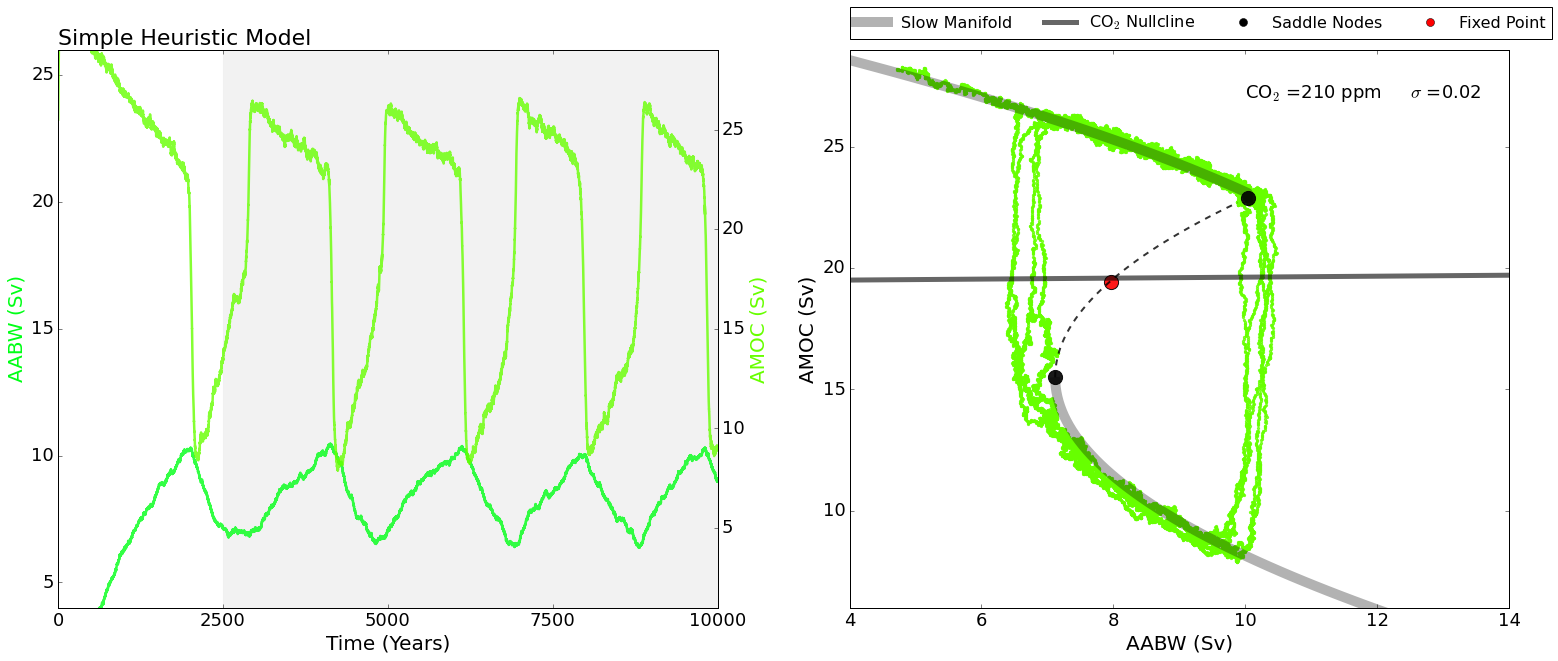

In [5]:
co2 = 210 # ppmv
ds = 5 # dotsize in the plots
#set to True to solve the stochastic ODE  with variance dw
shm(co2, ds, stochastic = True, dw = 0.02)

### Below is an interactive plot using ipywidgets (seems to be problems getting it to work correctly with mybinder)

In [7]:
co2arr = widgets.FloatSlider(description='CO$_2$',value=170, min=170, max=240, step=1)
dotsize = widgets.FloatSlider(description='dotsize',value=0.5, min=0.05, max=2, step=0.05)
box = Checkbox(False, description='stochastic')
dw = widgets.FloatSlider(description='$\sigma$',value=0.02, min=0.005, max=0.07, step=0.005)

out = widgets.interactive_output(shm, {'co2arr':co2arr, 'stochastic':box, 'dw':dw, 'dotsize':dotsize})

ui1 = widgets.HBox([co2arr, box, dw, dotsize], layout={'height':"100%",'width':"70%"})
ui2 = widgets.VBox([out])

display(ui2,ui1)